# Cell Embedding Visualization Demo

This notebook demonstrates how to:
1. Run inference on an h5ad file to extract cell embeddings
2. Attach embeddings to the AnnData object
3. Visualize using scanpy's UMAP

In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import json
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from uce_brain.model import UCEConfig, UCEForExpressionPrediction
from uce_brain.data import UCEDataCollator, H5ADDataset

## 1. Configuration

In [2]:
import os

# Gene data ships with this repo
REPO_ROOT = os.path.dirname(os.getcwd())  # assumes notebook is run from notebooks/
GENE_DATA_DIR = os.path.join(REPO_ROOT, "gene_data")

H5AD_PATH = "/data/kuan/benchmark_data/brain_organoid/281bf7bb-c74a-4daf-9069-f668e2b52c54.h5ad"
CHECKPOINT_PATH = "KuanP/uce-brain-pilot-8l-512d"
GENE_MAPPING_PATH = os.path.join(GENE_DATA_DIR, 'human_gene_dict.json')

# Inference settings
BATCH_SIZE = 32
DEVICE = "cuda"

print(f"Gene mapping path: {GENE_MAPPING_PATH}")

Gene mapping path: /home/kuan/dev-data-fm/UCE-brain/gene_data/human_gene_dict.json


## 2. Load h5ad File

In [3]:
# Load h5ad file
print(f"Loading h5ad file: {H5AD_PATH}")
adata = sc.read_h5ad(H5AD_PATH)
print(f"Loaded {adata.n_obs} cells x {adata.n_vars} genes")

# Show available metadata columns
print(f"\nAvailable metadata columns in adata.obs:")
print(list(adata.obs.columns))

Loading h5ad file: /data/kuan/benchmark_data/brain_organoid/281bf7bb-c74a-4daf-9069-f668e2b52c54.h5ad


Loaded 26499 cells x 27986 genes

Available metadata columns in adata.obs:
['batch', 'condition', 'Score.GO.0006096', 'Score.GO.0034976', 'Score.GO.0042063', 'Score.GO.0022008', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'disease_ontology_term_id', 'author_cell_type', 'cell_class', 'cell_subtype', 'cell_phase', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type_full_name', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid']


In [4]:
# Preview the metadata
adata.obs.head(10)

,batch,condition,Score.GO.0006096,Score.GO.0034976,Score.GO.0042063,Score.GO.0022008,tissue_ontology_term_id,tissue_type,assay_ontology_term_id,development_stage_ontology_term_id,...,cell_type_ontology_term_id,is_primary_data,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
AAACGAAGTTGCTAGT-1,84,CTRL,0.713477,-0.018800,0.171814,0.119208,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:0011026,True,progenitor cell,10x 3' v3,normal,male,neocortex,unknown,fetal stage,JGh0l`7*Kh
AAACGCTCACGTTCGG-1,84,CTRL,0.536049,0.042573,0.493402,0.594015,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:4042021,True,neuronal-restricted precursor,10x 3' v3,normal,male,neocortex,unknown,fetal stage,RB<dhxA@-X
AAAGGTAGTCCGTACG-1,84,CTRL,1.070184,0.055401,0.635225,0.506531,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:0011026,True,progenitor cell,10x 3' v3,normal,male,neocortex,unknown,fetal stage,KQ%FVh%+6{
AAAGGTAGTCGAACGA-1,84,CTRL,0.732770,-0.061755,0.180708,0.472909,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:0000695,True,Cajal-Retzius cell,10x 3' v3,normal,male,neocortex,unknown,fetal stage,GPyZ5EwCCW
AAAGGTAGTGTCCAAT-1,84,CTRL,0.180944,0.082616,0.618474,0.718798,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:4042021,True,neuronal-restricted precursor,10x 3' v3,normal,male,neocortex,unknown,fetal stage,|8a?bqd+Z{
AACAAAGGTAGGTAGC-1,84,CTRL,1.178196,-0.020723,0.440017,0.407893,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:0010012,True,cerebral cortex neuron,10x 3' v3,normal,male,neocortex,unknown,fetal stage,Qrvi50#xif
AACAACCAGAAAGTCT-1,84,CTRL,0.747554,0.055206,0.788236,0.809854,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:4042021,True,neuronal-restricted precursor,10x 3' v3,normal,male,neocortex,unknown,fetal stage,$U}G~Y<7`R
AACACACAGAGAACCC-1,84,CTRL,-0.669679,-0.627652,1.139589,2.333296,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:0010012,True,cerebral cortex neuron,10x 3' v3,normal,male,neocortex,unknown,fetal stage,g7%i3tqfRO
AACAGGGTCGCCTAGG-1,84,CTRL,0.438538,-0.063514,0.304682,0.276359,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:4042021,True,neuronal-restricted precursor,10x 3' v3,normal,male,neocortex,unknown,fetal stage,#IBy)kP;Rc
AACCAACGTAAGGCCA-1,84,CTRL,-0.504367,-0.463310,1.249811,1.605957,UBERON:0001950,organoid,EFO:0009922,HsapDv:0000037,...,CL:0010012,True,cerebral cortex neuron,10x 3' v3,normal,male,neocortex,unknown,fetal stage,AH1Hm-qv+{


## 3. Extract Cell Embeddings

In [5]:
# Load gene mapping
print("Loading gene mapping...")
with open(GENE_MAPPING_PATH, 'r') as f:
    gene_mapping = json.load(f)

Loading gene mapping...


In [6]:
# Load model
print(f"Loading model from: {CHECKPOINT_PATH}")
config = UCEConfig.from_pretrained(CHECKPOINT_PATH)
print(f"Model config: vocab_size={config.vocab_size}, d_model={config.d_model}, layers={config.num_layers}")

model = UCEForExpressionPrediction.from_pretrained(CHECKPOINT_PATH)
model = model.to(DEVICE)
model.eval()

Loading model from: KuanP/uce-brain-pilot-8l-512d


2026-02-27 09:47:28,600 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/KuanP/uce-brain-pilot-8l-512d/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-27 09:47:28,692 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/KuanP/uce-brain-pilot-8l-512d/32eb9ee0e1723e11f5151128ba0049ec68ce68c4/config.json "HTTP/1.1 200 OK"
2026-02-27 09:47:28,810 - httpx - INFO - HTTP Request: GET https://huggingface.co/api/resolve-cache/models/KuanP/uce-brain-pilot-8l-512d/32eb9ee0e1723e11f5151128ba0049ec68ce68c4/config.json "HTTP/1.1 200 OK"


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

2026-02-27 09:47:29,242 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/KuanP/uce-brain-pilot-8l-512d/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-27 09:47:29,260 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/KuanP/uce-brain-pilot-8l-512d/32eb9ee0e1723e11f5151128ba0049ec68ce68c4/config.json "HTTP/1.1 200 OK"


Model config: vocab_size=145469, d_model=512, layers=8


2026-02-27 09:47:29,364 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/KuanP/uce-brain-pilot-8l-512d/resolve/main/model.safetensors "HTTP/1.1 302 Found"
2026-02-27 09:47:29,691 - httpx - INFO - HTTP Request: GET https://huggingface.co/api/models/KuanP/uce-brain-pilot-8l-512d/xet-read-token/32eb9ee0e1723e11f5151128ba0049ec68ce68c4 "HTTP/1.1 200 OK"


model.safetensors:   0%|          | 0.00/3.10G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/118 [00:00<?, ?it/s]

UCEForExpressionPrediction(
  (uce): UCEModel(
    (embedding_layer): ProteinEmbeddingLayer(
      (embedding): Embedding(145469, 5120, padding_idx=0)
      (layer_norm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
    )
    (input_gene_embedding_projector): Sequential(
      (0): Linear(in_features=5120, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
    )
    (pos_encoder): SinusoidalPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=20

In [7]:
# Create dataset
print("Creating dataset...")
dataset = H5ADDataset(
    adata,
    gene_mapping=gene_mapping,
    gene_symbol_column='feature_name'
)

# Create dataloader
collator = UCEDataCollator()
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collator,
    pin_memory=True,
)

print(f"Dataset size: {len(dataset)} cells")
print(f"Number of batches: {len(dataloader)}")

2026-02-27 09:48:22,461 - uce_brain.data.dataset - INFO - Loading AnnData object with shape (26499, 27986)
2026-02-27 09:48:22,462 - uce_brain.data.dataset - INFO - Loaded 26499 cells with 27986 genes
2026-02-27 09:48:22,463 - uce_brain.data.dataset - INFO - var_names are Ensembl IDs, looking for gene symbols...
2026-02-27 09:48:22,466 - uce_brain.data.dataset - INFO - Using gene symbols from column 'feature_name'
2026-02-27 09:48:22,469 - uce_brain.data.dataset - INFO - Aligning h5ad genes to gene mapping...
2026-02-27 09:48:22,474 - uce_brain.data.dataset - INFO -   H5AD genes: 27986
2026-02-27 09:48:22,475 - uce_brain.data.dataset - INFO -   Gene mapping vocabulary: 19656
2026-02-27 09:48:22,475 - uce_brain.data.dataset - INFO -   Genes in common: 16693


Creating dataset...
Dataset size: 26499 cells
Number of batches: 829


In [8]:
# Extract embeddings
print("Extracting cell embeddings...")

all_cell_embeddings = []
all_cell_indices = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Extracting embeddings"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)

        outputs = model.extract_cell_embeddings(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        all_cell_embeddings.append(outputs.cell_embedding.cpu().numpy())
        all_cell_indices.append(batch["cell_indices"].cpu().numpy())

# Concatenate results
cell_embeddings = np.vstack(all_cell_embeddings)
cell_indices = np.concatenate(all_cell_indices)

Extracting cell embeddings...


Extracting embeddings:   0%|          | 0/829 [00:00<?, ?it/s]

/home/kuan/dev-data-fm/UCE-brain/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:531: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


## 4. Attach Embeddings to AnnData

In [9]:
# Attach embeddings to adata.obsm
adata.obsm['X_uce'] = cell_embeddings
print(f"Attached embeddings to adata.obsm['X_uce'] with shape {adata.obsm['X_uce'].shape}")

Attached embeddings to adata.obsm['X_uce'] with shape (26499, 512)


## 5. Compute UMAP using Scanpy

In [10]:
# Compute neighbors using UCE embeddings
print("Computing neighbors...")
sc.pp.neighbors(adata, use_rep='X_uce')

Computing neighbors...


In [11]:
# Compute UMAP
print("Computing UMAP...")
sc.tl.umap(adata)

Computing UMAP...


## 6. Visualize with Scanpy

Visualizing UMAP...


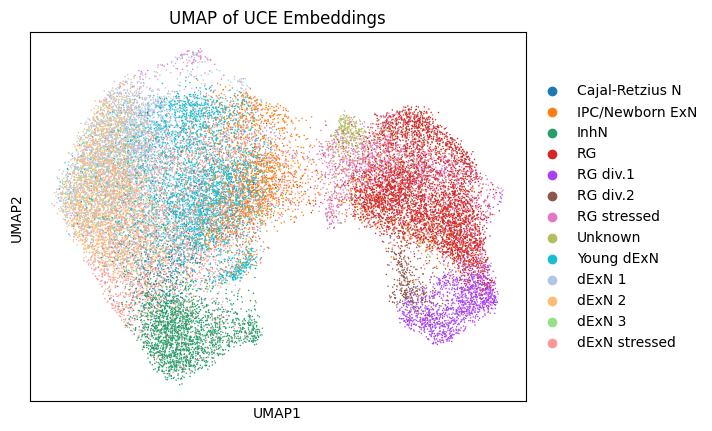

In [12]:
# Visualize
print("Visualizing UMAP...")
sc.pl.umap(adata, color='cell_subtype', title='UMAP of UCE Embeddings', show=True)

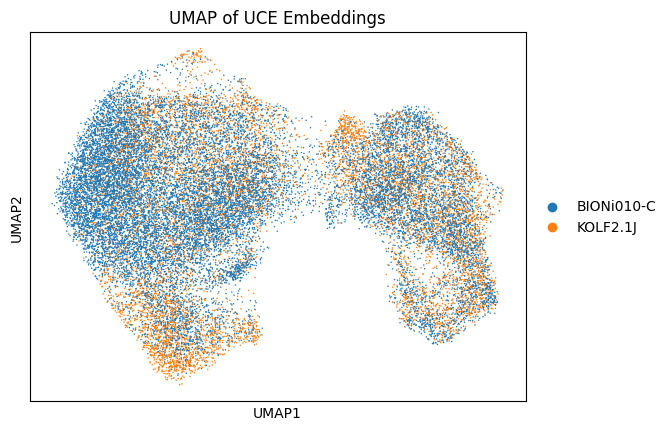

In [13]:
sc.pl.umap(adata, color='donor_id', title='UMAP of UCE Embeddings', show=True)